<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_15m_LSTM_CNC_without_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=a0f212f9fd04b9d546f7db674d85fbd54410402fb307dd2027b412611d575682
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [ ]:
import yfinance as yf
fifteen_m_data = yf.download(tickers='AAPL', period = '60d', interval = '15m')
fifteen_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-08-02 09:30:00-04:00,146.360001,146.949997,145.270004,145.399994,145.399994,8494835
2021-08-02 09:45:00-04:00,145.500000,146.009995,145.369995,145.949997,145.949997,4055907
2021-08-02 10:00:00-04:00,145.903000,146.240005,145.600006,146.060104,146.060104,3518727
2021-08-02 10:15:00-04:00,146.059998,146.250000,145.600006,145.910004,145.910004,2567609
2021-08-02 10:30:00-04:00,145.910004,145.990005,145.410004,145.539993,145.539993,2267311
...,...,...,...,...,...,...
2021-10-25 10:30:00-04:00,147.910004,148.080002,147.740097,147.850006,147.850006,1619209
2021-10-25 10:45:00-04:00,147.850006,148.080002,147.779999,148.078705,148.078705,1246181
2021-10-25 11:00:00-04:00,148.074997,148.289993,147.830002,148.235001,148.235001,1444939


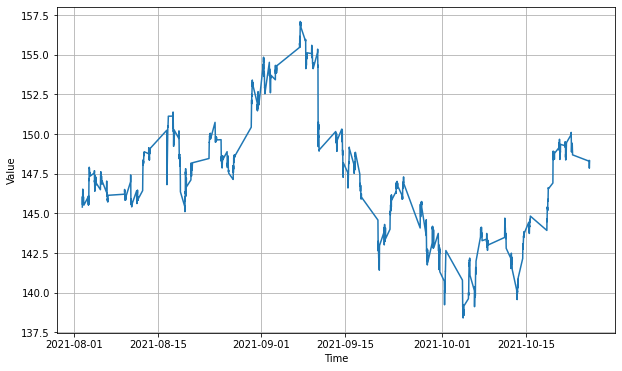

In [ ]:
#from sklearn.preprocessing import StandardScaler

#series = one_d_data['Close'].values.reshape(-1, 1)
#scaler = StandardScaler()
#scaler.fit(series[:len(series) // 2])
#series = scaler.transform(series).flatten()

series = np.array(fifteen_m_data.Close)
time = np.array(fifteen_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
4/4 [==============================] - 4s 66ms/step - loss: 127.4510 - mae: 127.9511
Epoch 2/100
4/4 [==============================] - 0s 43ms/step - loss: 126.9284 - mae: 127.4284
Epoch 3/100
4/4 [==============================] - 0s 42ms/step - loss: 125.9771 - mae: 126.4771
Epoch 4/100
4/4 [==============================] - 0s 42ms/step - loss: 124.6723 - mae: 125.1723
Epoch 5/100
4/4 [==============================] - 0s 41ms/step - loss: 123.0554 - mae: 123.5554
Epoch 6/100
4/4 [==============================] - 0s 39ms/step - loss: 121.1450 - mae: 121.6450
Epoch 7/100
4/4 [==============================] - 0s 41ms/step - loss: 118.9426 - mae: 119.4426
Epoch 8/100
4/4 [==============================] - 0s 40ms/step - loss: 116.4380 - mae: 116.9380
Epoch 9/100
4/4 [==============================] - 0s 42ms/step - loss: 113.6127 - mae: 114.1127
Epoch 10/100
4/4 [=======

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 4s 35ms/step - loss: 57.6633 - mae: 58.1593
Epoch 2/150
10/10 [==============================] - 1s 35ms/step - loss: 10.6156 - mae: 11.1021
Epoch 3/150
10/10 [==============================] - 1s 35ms/step - loss: 6.2585 - mae: 6.7337
Epoch 4/150
10/10 [==============================] - 1s 34ms/step - loss: 4.4652 - mae: 4.9229
Epoch 5/150
10/10 [==============================] - 1s 34ms/step - loss: 4.1465 - mae: 4.6037
Epoch 6/150
10/10 [==============================] - 1s 34ms/step - loss: 3.9068 - mae: 4.3627
Epoch 7/150
10/10 [==============================] - 1s 35ms/step - loss: 3.7065 - mae: 4.1651
Epoch 8/150
10/10 [==============================] - 1s 34ms/step - loss: 3.5481 - mae: 4.0060
Epoch 9/150
10/10 [==============================] - 1s 35ms/step - loss: 3.5167 - mae: 3.9765
Epoch 10/150
10/10 [==============================] - 1s 35ms/step - loss: 3.2141 - mae: 3.6721
Epoch 11/150
10/10 [=========================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

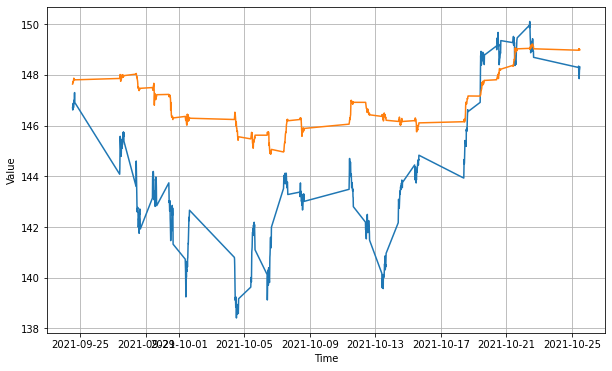

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.172106

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS